## Project Motivation and Idea
Considering the enormous amount of money in todays football market, the building of a well-functioning roster with players interacting collaboratively together becomes an incredibly important task with high stakes. Therefore any insight into how a team performs together, which players are the pillars of the team and which players could be replaced for performance enhancement could be worth millions. 

Using network analysis on professional football teams adds something new and remarkable to sports analytics. While normal sports analytics is often about different metrics for evaluating players' performance, without considering the interaction between teammates network analysis might be able to actually extract patterns of play, show interaction between certain sets of players and give us an idea to how certain teams set up their offense. 

There have been different approaches using network analysis on football teams, however they often fall short.
Generally, adjacency matrices are built from all possessions observed. This leads to the defensive and central midfielders almost always showing up as the most important players for each team. This might make sense, since they are often in the center of play, however this is not an interesting or trustworthy find if you claim that the central midfielder is the most important player in every team.
In this project, I try to take a different approach by looking only at possessions that ended in a shot. Doing this we take care of two possible problems:

i) We only look at possessions where the team actually looked to score. Short possessions in your own half are not considered vital to the overall game. Players that have the ball often in those possessions (defenders, central midfielders and even goalkeepers) will not show up as central, if they do not contribute to offensive play.

ii) We can assign a value to each of the possessions using an expected Goals model. This gives us an idea of how big the chance was. This value can be used to assign each of the players a value according to their contribution. The main idea is here: if you create a lot of good chances, you are a good (offensive) player.

In [27]:
# reading in all necessary libraries
import networkx as nx
import os
import pandas as pd
os.chdir('/home/Nickfis/Documents/Projects/football_network_analysis/')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re
import math
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline

## Reading in data

The dataframes that are loaded in here were derived earlier from the overall event data for the season

plus qualifiers that explain each event more precisely. 
This means the possession as well as the xg_features data is based on multiple assumptions made by me.
The possessions df gives each offensive possession in the season that ended in a shot. An offensive possession
is just defined as a sequence of passes from only one team that ended in a shot.
XG_features is basically a dataframe with about 16.000 rows of shots, with certain features that describe the
shot more closely, in order to obtain a probability for that shot going in. In this project, we only need to 
look at the probability of the shot going in, since this will give us a measure of danger of that offensive
possession. 

In [28]:
# event data: all events that occurred in every game of LaLiga over the season 2017/2018
event = pd.read_csv('event2017.csv')
# possession dataframes. All offensive possessions that ended in a shot
possession = pd.read_csv('possession2017.csv')
# expected goals 
xg_features = pd.read_csv('xg_features2017.csv')
# team and playerspecific information
teams = pd.read_csv('teams.csv')
allplayers = pd.read_csv('player_frame.csv')


FileNotFoundError: File b'possession2017.csv' does not exist

In [ ]:
# possession shape needs to be a little bit preprocessed.
# drop the duplicates
possession = possession[~possession.duplicated(keep='first')]
# leave out na's because not part of possession and not a player
possession = possession[~possession['player_id'].isna()]
# only look at shots and passes
shotsandpass = [1,13,14,15,16]
possession = possession[possession['event_type'].isin(shotsandpass)]
possession.index = possession['possession']
# deleting all possessions with fewer than 3 actions
possession = possession[pd.DataFrame(possession['possession'].value_counts())['possession']>2]

We will see that our y and x axis both range from 0 to 100. In reality though, the pitch is obviously not a square. Here I took a ratio, that should transform the y-coordinates in an adequate manner. 

In [ ]:
# check for the y-coordinate
possession['y'].describe()

In [ ]:
ratio=105/69.5

possession['y'] = possession['y']/ratio

## Building Adjacency Matrices according to amount of passes for each team

In the following block of code the "normal" adjacency matrices are going to be built. For every outgoing and incoming pass for each player in the offensive possessions a one will be added to their cell in the matrix. 
What we will end up with is a matrix of all players involved in possessions that led to a shot with a cell describing the passes they played and another cell showing how many passes they received. 

Furthermore the loop is used to create another dataframe for each team, observing the average position of the players involved, in order to draw the offensive graph later on.

In [ ]:
#create adjacency matrix for each team
for team in possession['team_id'].unique():
    team_pos = possession[possession['team_id']==team]
    # create adjacency matrix for that team
    team_player = team_pos['player_id'].unique()
    # player x player matrix
    adj_matrix = pd.DataFrame(np.zeros((len(team_player),len(team_player))))
    # name indices
    adj_matrix.columns = team_player
    adj_matrix.index = team_player
    # loop through every possession for the team and add received / played passes for each player
    for pos in team_pos['possession'].unique():
        one_pos = team_pos[team_pos['possession']==pos]
        #print(pos)
        # now go back more and more in the dataframe till the beginning
        # first pass
        for k in range((one_pos.shape[0]-1),0,-1):
            #print(k)
            # player that passes the ball
            i = one_pos.iloc[k]['player_id']
            # player that receives the pass
            j = one_pos.iloc[k-1]['player_id']
            # filling up the values
            adj_matrix.loc[i,j]+=1

    ############################################ BUILDING POSITION DATAFRAME #########################################################
    # in another dataframe for that team I want to have all the players and their median (mean?) position and their number of actions
    # a df with 3 columns with the length of the players in the adjacency matrix, maybe even do a density of each player?
    team_positions = pd.DataFrame(team_player)
    team_positions.index = team_player
    # add positions
    team_positions['x'] = 0
    team_positions['y'] = 0
    # actions
    team_positions['actions'] = 0

    for i in team_player:
        #player_pos = team_pos[team_pos['player_id']==i]
        team_positions.loc[i,'x'] = team_pos[team_pos['player_id']==i]['x'].mean()
        team_positions.loc[i,'y'] = team_pos[team_pos['player_id']==i]['y'].mean()
        team_positions.loc[i, 'actions'] = len(team_pos[team_pos['player_id']==i]['possession'])


    team_positions.to_csv('data/positions_'+str(team)+'.csv')
    adj_matrix.to_csv('data/adj_matrix_'+str(team)+'.csv')

## Building Adjacency Matrices according to xG value for each team
Although the previously created adjacency matrices already depict better what is going on in an offensive network, we want to be more precise. 
Using a previously created xG-Model with certain features that are supposed to help evaluate whether we are looking at a chance with a high or low probability of going in, we want to assign each possession a value.
This value will be between 0 and 1, since it is basically the probability of the team scoring the shot.
Amongst the features of the model are the distance, the type of shot (header/foot), whether it was a shot set up by a teammate, the pass that led to the shot and more. This model achieves overall over 80% area under the curve.
After assigning the probability of each shot to its possession, the players are rewarded uniformly. Of course these weights can be changed (to exponential or according to a pass probability model or by x amount of other methods), but here I try to keep it simple for now. 
The general idea behind a uniform distribution of reward is: if a player is often involved with great chances, he  should show up as a great contributor, no matter of the position. There is a reason why certain defenders will initiate dangerous possessions more frequently than others. 

In [ ]:
## add the goal probability to the possession dataframe
goal_prob = pd.merge(possession[['unique_event_id', 'possession']], xg_features[['unique_event_id', 'goal_prob']], how='right', on='unique_event_id')
possession = pd.merge(possession, goal_prob.dropna(subset=['goal_prob'])[['possession', 'goal_prob']], on='possession', how='left')
possession = possession.drop_duplicates(subset='unique_event_id')

for team in possession['team_id'].unique():
    #print(team)
    team_pos = possession[possession['team_id']==team]
    # create adjacency matrix for that team
    team_player = team_pos['player_id'].unique()
    # player x player matrix
    adj_matrix = pd.DataFrame(np.zeros((len(team_player),len(team_player))))
    # name indices
    adj_matrix.columns = team_player
    adj_matrix.index = team_player
    # loop through every possession for the team and add received / played passes for each player
    for pos in team_pos['possession'].unique():
        one_pos = team_pos[team_pos['possession']==pos]
        value = one_pos['goal_prob'].iloc[0]/one_pos.shape[0]
        #print(pos)
        # now go back more and more in the dataframe till the beginning
        # first pass
        for k in range((one_pos.shape[0]-1),0,-1):
            #print(k)
            # player that passes the ball
            # player that passes
            i = one_pos.iloc[k]['player_id']
            #print(i)
            # player that receives the pass
            j = one_pos.iloc[k-1]['player_id']
            # filling up the values
            adj_matrix.loc[i,j]+=value

    adj_matrix.to_csv('/data/xg_adj_matrix_'+str(team)+'.csv')

## Visualization of offensive networks

In the following sections we take a look at the different offensive networks of 6 selected teams. In order to be able to graph an offensive network for all 30 teams in the league, we select the 10 players with the most actions in the evaluated possessions. This should be a proxy for selecting the players that usually get the most playing time. Of course this does not work 100% in giving us an actual starting eleven of a team, since offensive players will more often contribute to a created chance. 
This is supposed to give a first insight as to how certain teams play. In the 6 selected teams we will see a lot of different playing styles, some teams focussing to play through the middle, while others make sure to use the wings. 
For Real Sociedad for example we will see, that no player on the left wing is contributing much to the offensive network. 
If you are more interested in certain teams and players, this can of course be adapted to give a better feeling.

In [29]:
######## for loop for every file in the directory
allfiles = os.listdir()
csv_files = [csv for csv in allfiles if csv.endswith(".csv")]

adj_matrix_files = [csv for csv in csv_files if csv.startswith("adj")]
position_files = [csv for csv in csv_files if csv.startswith('positions')]

### Using adjacency matrices with passes played
In the first visualization we are going to look at just the incoming and outgoing passes in the attacking possessions. The node size is the overall amount of passes played in the attacking possesions, while the thickness of the edges is showing the amount of incoming and outgoing passes to the other player.

/home/Nickfis/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'player_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


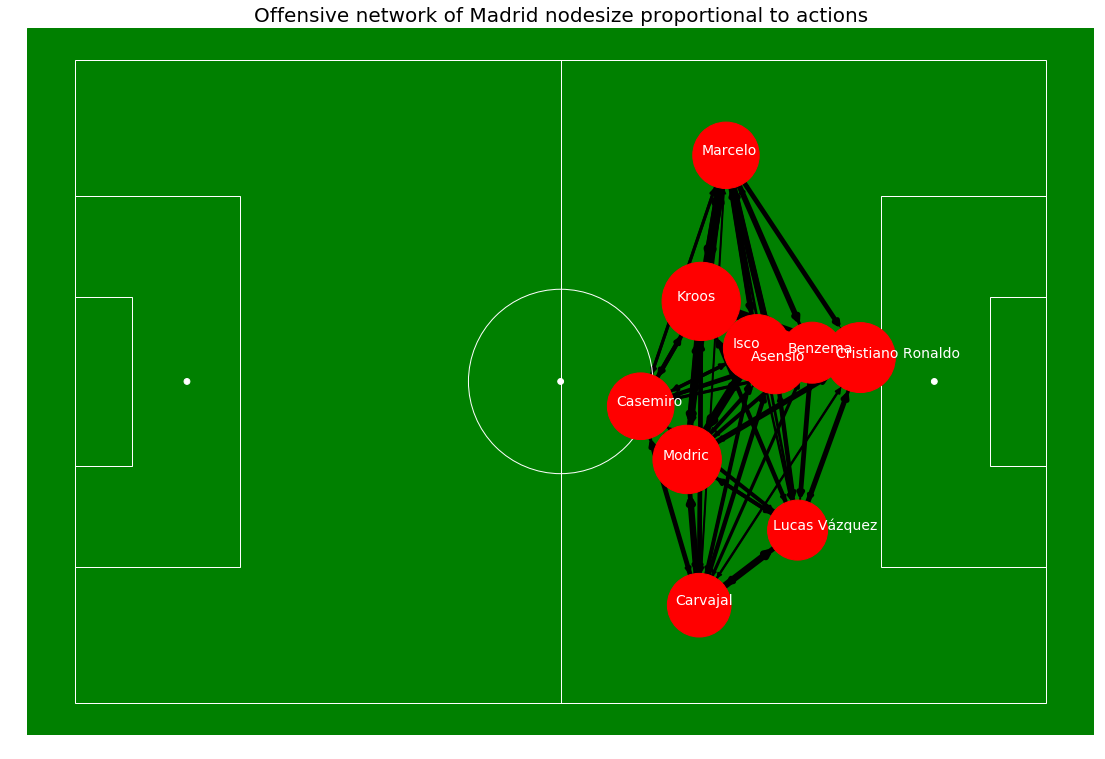

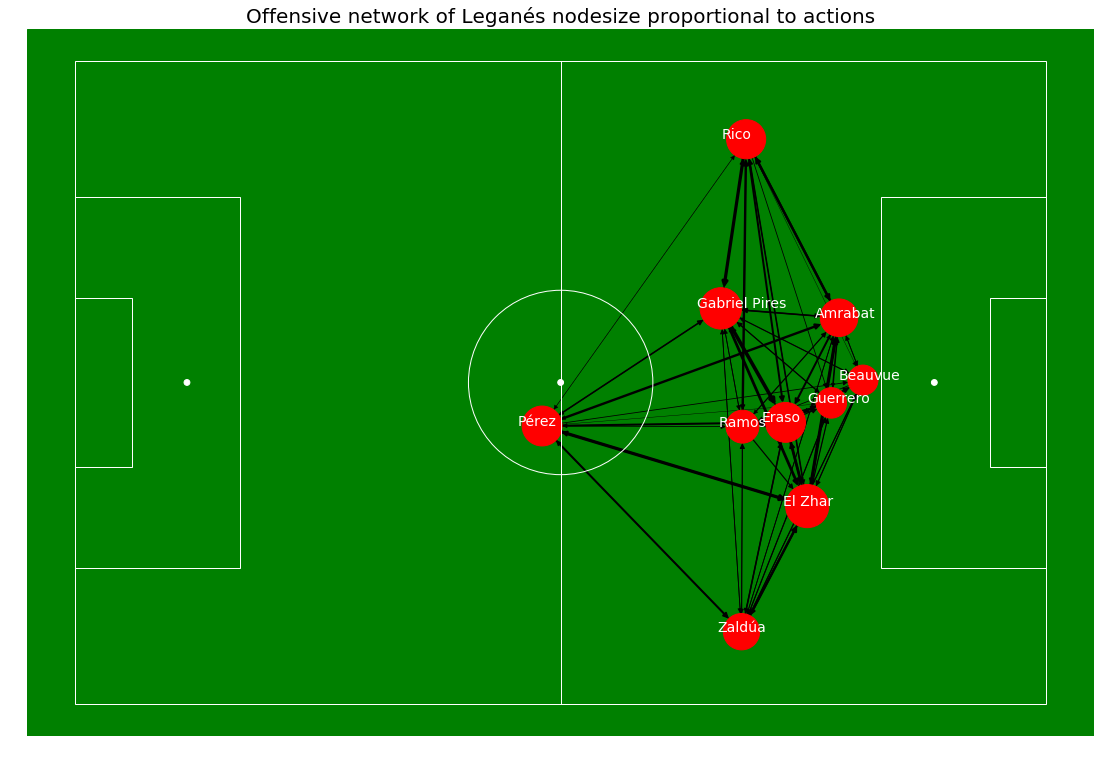

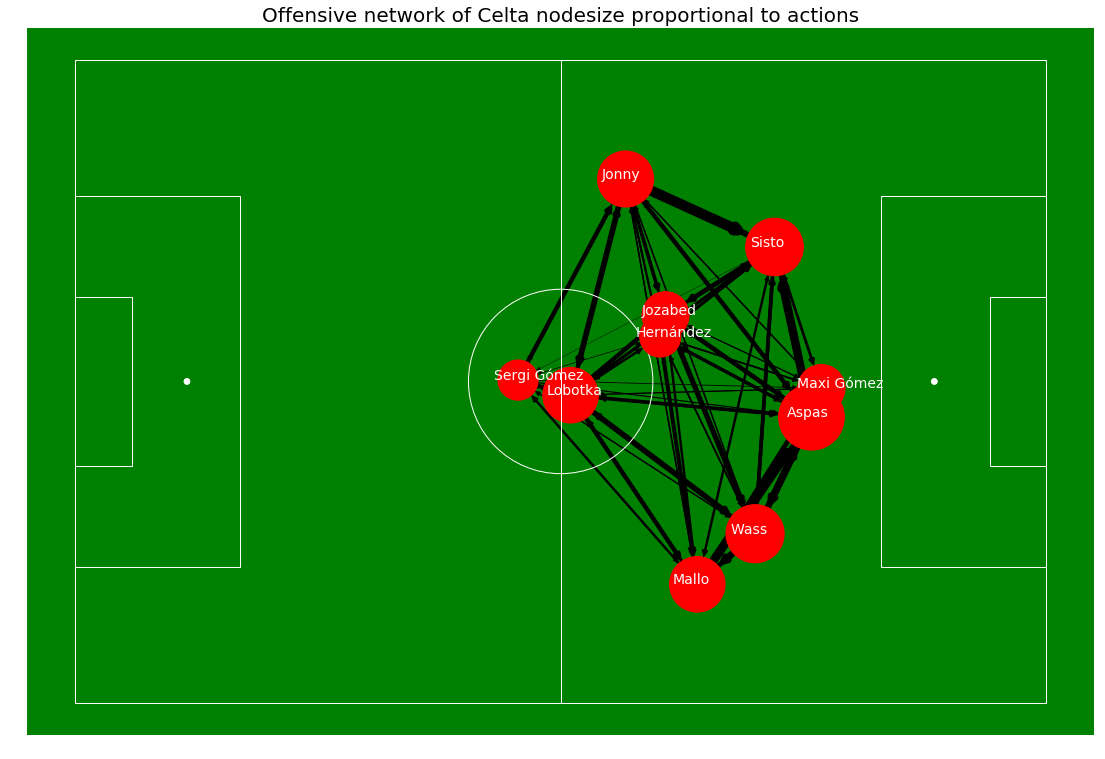

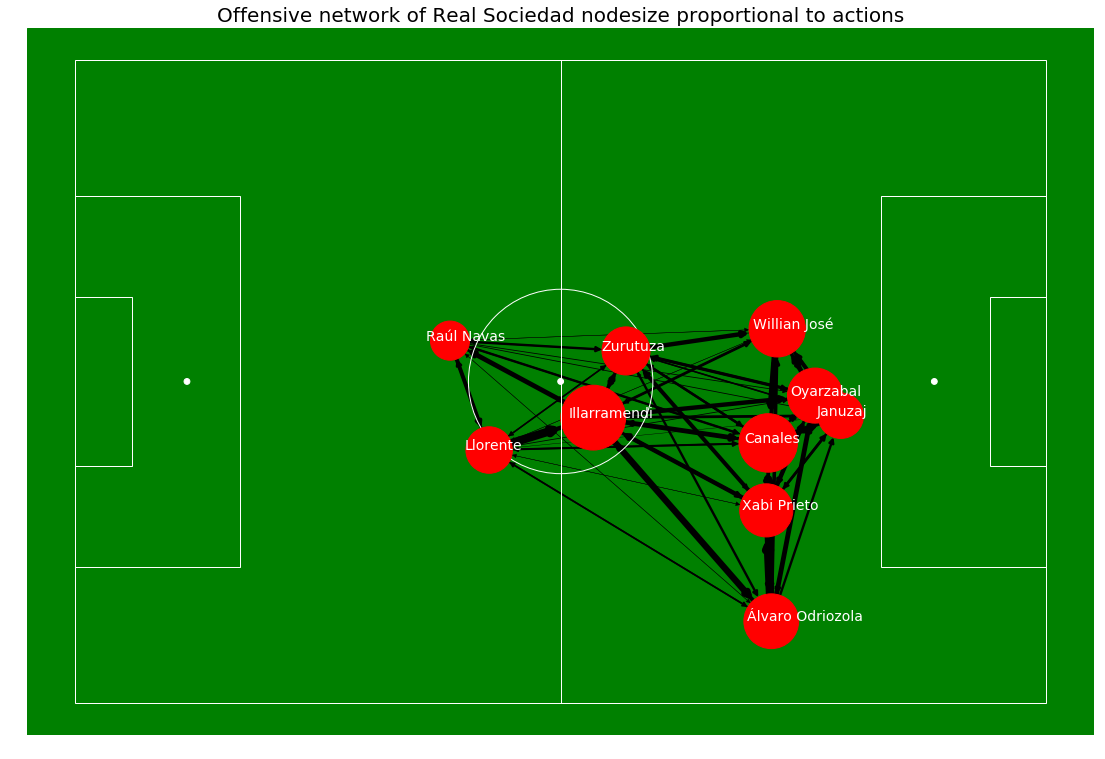

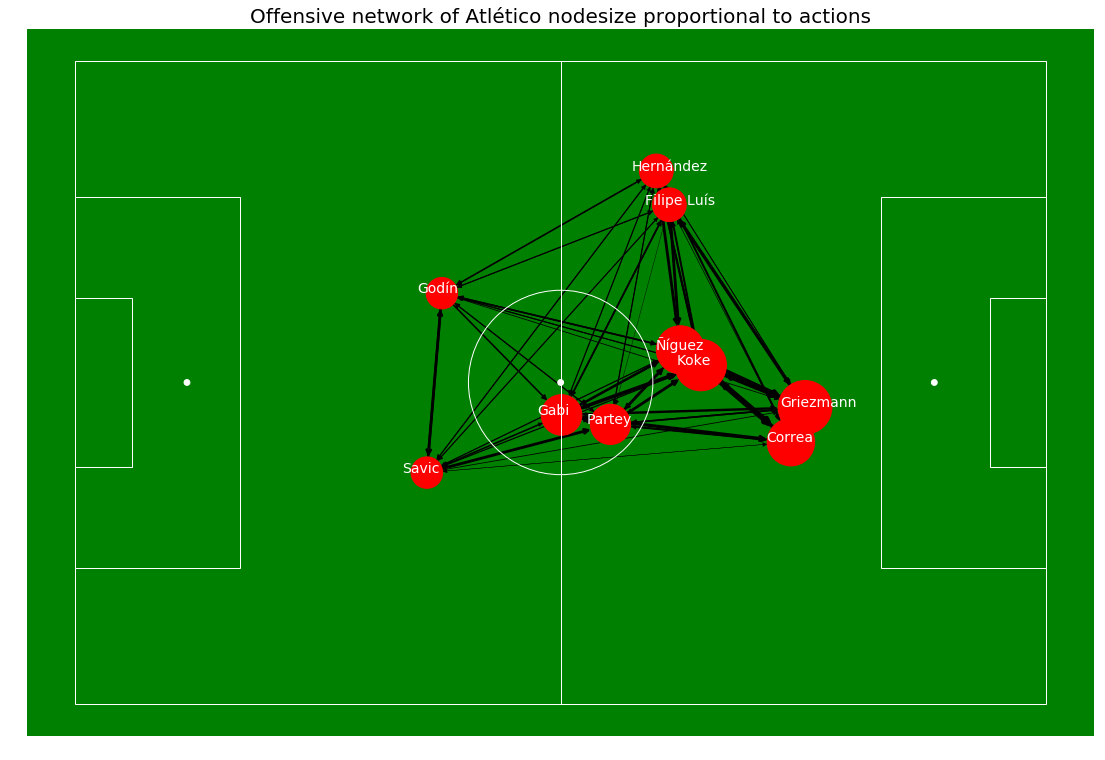

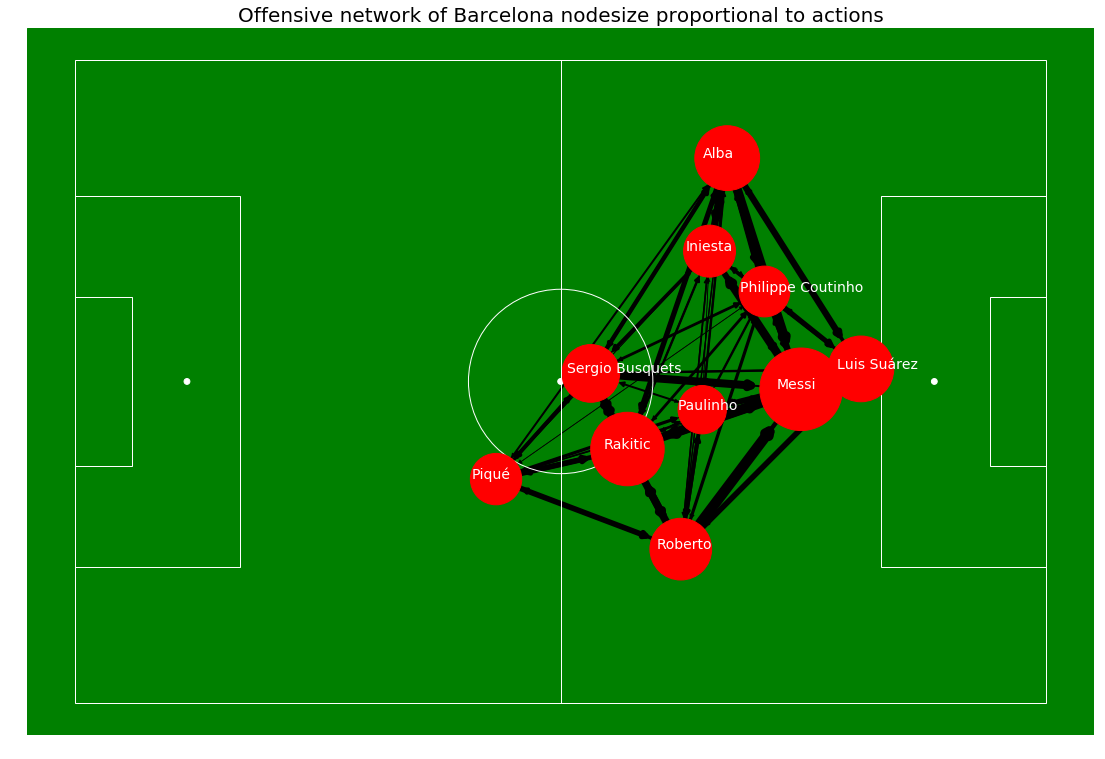

In [30]:
for i in adj_matrix_files:
    team_id = ''.join([s for s in i if s.isdigit()])
    for j in position_files:
        # if the team number is the same we take i and j as our files to plot stuff
        if team_id == ''.join([n for n in j if n.isdigit()]):
            # now j is matching with the team id, so LET'S GO
            # reading in the data
            adj_matrix = pd.read_csv(i)
            pos_df = pd.read_csv(j)

            ####################################### preprocessing ####################################
            del pos_df['Unnamed: 0']
            pos_df.columns = ['player_id', 'x', 'y', 'actions']
            pos_df.index = pos_df['player_id']

            # i need the team number of each entry in each list
            adj_matrix.index = adj_matrix['Unnamed: 0'].astype(str)
            del adj_matrix['Unnamed: 0']
            del adj_matrix.index.name


            # for plotting I have to adjust the players position by 5 for x and 5/ratio for y
            pos_df['x'] = pos_df['x'] + 5
            pos_df['y'] = pos_df['y'] + (5 / ratio)

            # subsetting for the eleven players with the highest actions
            pos_df = pos_df.sort_values(by='actions', ascending=False).iloc[0:10]
            size = 30*(np.array(pos_df.sort_values(by='actions', ascending=False).iloc[0:10]['actions']))
            # getting players names to put labels
            players_of_team = pd.merge(pos_df, allplayers, on='player_id')[['player_id','last_name','known_name', 'x', 'y']]
            players_of_team.index = players_of_team['player_id'].astype(float)

            #### GOTTA MAKE THE ADJ MATRIX 10x10 AT THIS POINT AND ORDER CORRECTLY ################################
            adj_matrix.columns = np.array(adj_matrix.index).astype(float)
            adj_matrix.index = np.array(adj_matrix.index).astype(float)

            # subset adj matrix
            adj_matrix = adj_matrix.loc[players_of_team.index, players_of_team.index]

            # so positions of players I can just append list style, done.
            positions = []
            player_index = []
            for pp in np.array(adj_matrix.index).astype(float):
                if pp in pos_df['player_id']:
                    player_pos = []
                    player_pos.append(pos_df.loc[pp]['x'])
                    player_pos.append(pos_df.loc[pp]['y'])
                    positions.append(player_pos)
                    player_index.append(pp)

            #adj_matrix
            adj_matrix.columns = range(len(adj_matrix))
            adj_matrix.index = range(len(adj_matrix))

            ### create the pitch
            ### now plot the graph on top
            graph = nx.DiGraph(adj_matrix)
            # get width of edges
            edges = graph.edges
            weights = [graph[u][v]['weight'] for u,v in edges]
            # different colors to model intensity
            greys = cm = plt.get_cmap('binary')
            cNorm  = colors.Normalize(vmin=min(weights), vmax=max(weights))
            scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=greys)
            colorList = []

            for number_edge in range(len(edges)):
              colorVal = scalarMap.to_rgba(weights[number_edge])
              colorList.append(colorVal)


            # own solution
            topleft=[0,110]
            topright=[110,110]
            bottomleft=[0,0]
            bottomright=[110,0]
            width = abs(topleft[0] - topright[0])
            height = abs(bottomleft[1] - topleft[1])
            xlims = (0, 110)
            ylims = (0, 110/ratio)

            fig1 = plt.figure(figsize=(20,13))
            ax1 = fig1.add_subplot(111, aspect='equal')
            # general green pitch, reaches from 0 - 110 to paint pitch on it
            ax1.add_artist(plt.Circle((55, 55/ratio), 9.5, color='w', fill=False))
            # add penalty point
            ax1.add_artist(plt.Circle((93.5, 55/ratio), 0.3, color='w'))
            # add second point
            ax1.add_artist(plt.Circle((16.5, 55/ratio), 0.3, color='w'))
            # add center point
            ax1.add_artist(plt.Circle((55, 55/ratio), 0.3, color='w'))
            # green surrounding
            ax1.add_patch(
                patches.Rectangle((0, 0/ratio), width, height/ratio, color='g'))
            # marking the field
            ax1.add_patch(
                patches.Rectangle((5, 5/ratio), 100, 100/ratio, fill=False, color='w'))
            # penalty box
            ax1.add_patch(
                patches.Rectangle((5, 26.1/ratio), 17, 57.8/ratio, fill=False, color='w'))
            ax1.add_patch(
                patches.Rectangle((88, 26.1/ratio), 17, 57.8/ratio, fill=False, color='w'))
            ax1.add_patch(
                patches.Rectangle((5, 41.8/ratio), 5.8, 26.4/ratio, fill=False, color='w'))
            ax1.add_patch(
                patches.Rectangle((99.2, 41.8/ratio), 5.8, 26.4/ratio, fill=False, color='w'))
            nx.draw(graph, positions, node_size = size, width=[w/2.5 for w in weights])
            plt.plot([55, 55], [5/ratio,105/ratio], color='w', linestyle='-', linewidth=1)
            plt.ylim(ylims)
            plt.xlim(xlims)

            ### now add labels of the players names on top
            # players_of_team = pd.merge(pos_df, allplayers, on='player_id')[['player_id','last_name', 'x', 'y']]
            for z in players_of_team['player_id']:
                if pd.isnull(players_of_team.loc[z]['known_name']):
                    plt.annotate(players_of_team.loc[z]['last_name'], xy=(players_of_team.loc[z]['x']-2.5, players_of_team.loc[z]['y']), color='white', fontsize=14)
                else:
                    plt.annotate(players_of_team.loc[z]['known_name'], xy=(players_of_team.loc[z]['x']-2.5, players_of_team.loc[z]['y']), color='white', fontsize=14)

            # add title
            plt.title('Offensive network of ' + str(teams[teams['team_id']==float(team_id)]['short_name'].iloc[0]) + ' nodesize proportional to actions', fontsize=20)
            plt.savefig(str(team_id) +'_offensive_network.png')

## Using xG-adjacency matrices for offensive networks
In the following visualization we will utilize the previously created adjacency matrices that show the offensive contribution by players regarding their added value in expected Goals. This should give us a better feeling for who consistently is involved in high probability chances.
The node size is here according to their overall added offensive value. This value was calculated in another project, but can be read as the overall created goals over a whole season. Player with bigger nodes are therefore more important in the offensive flow of a team. 

In [31]:
# reading in the added value by each player
chance_metric = pd.read_csv('chance_creation2017.csv')

/home/Nickfis/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'player_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


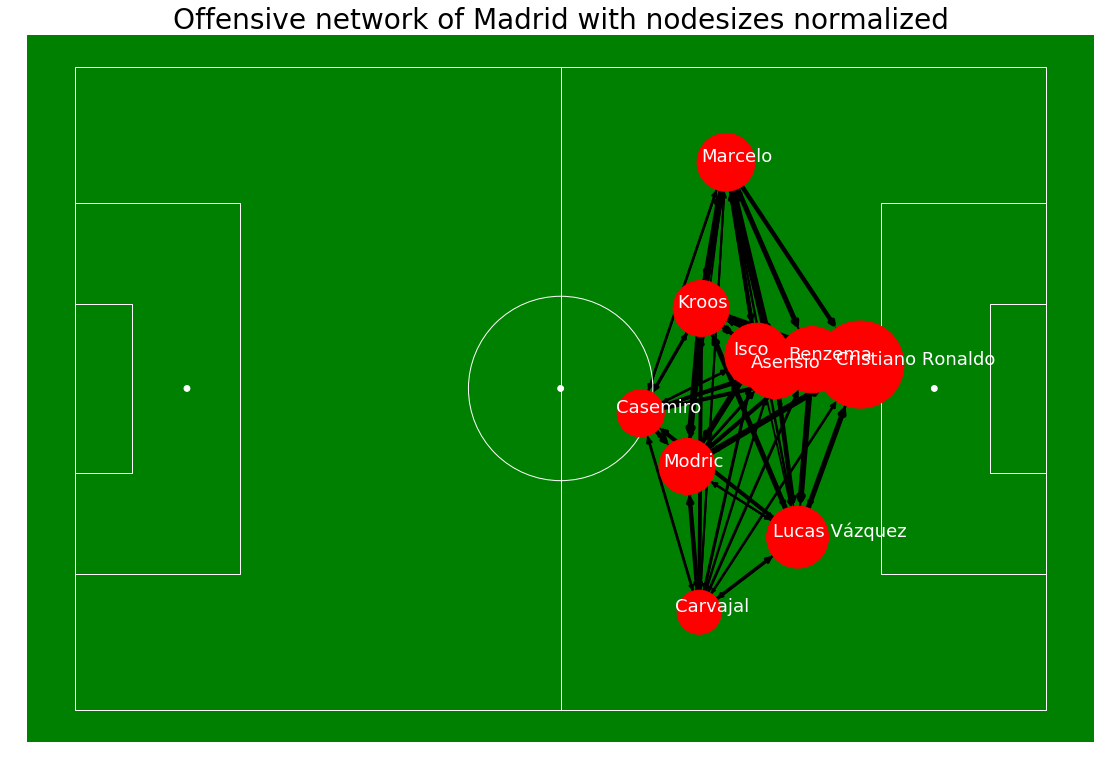

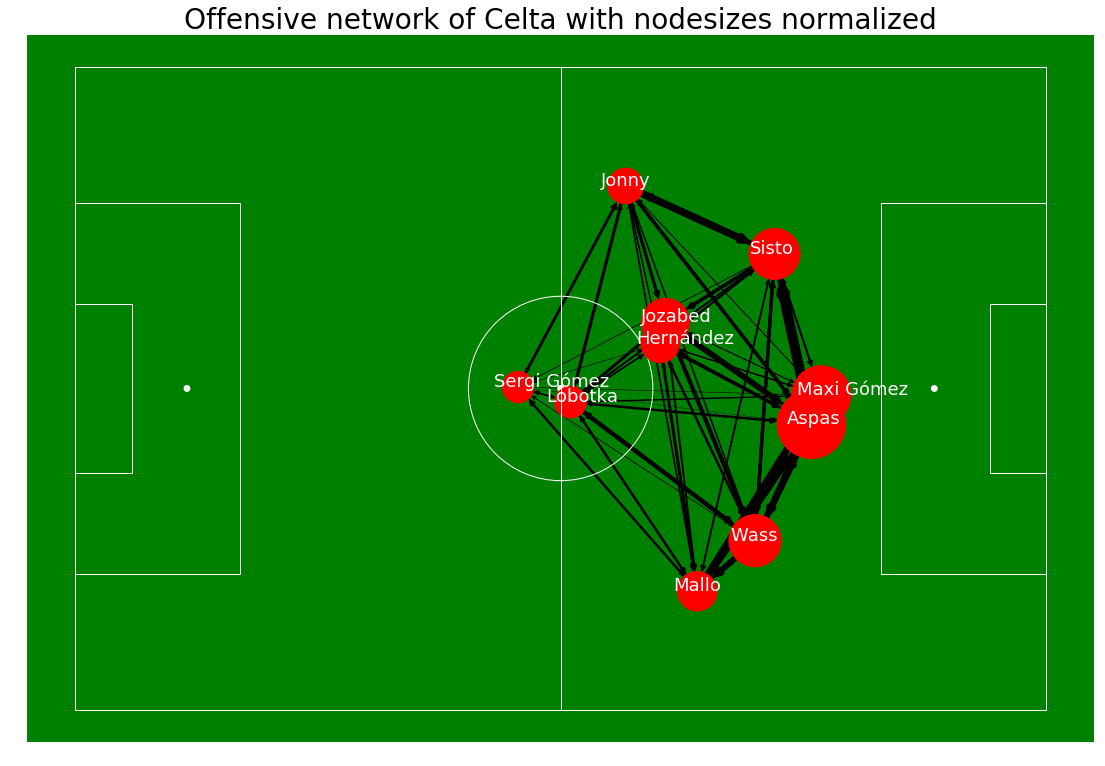

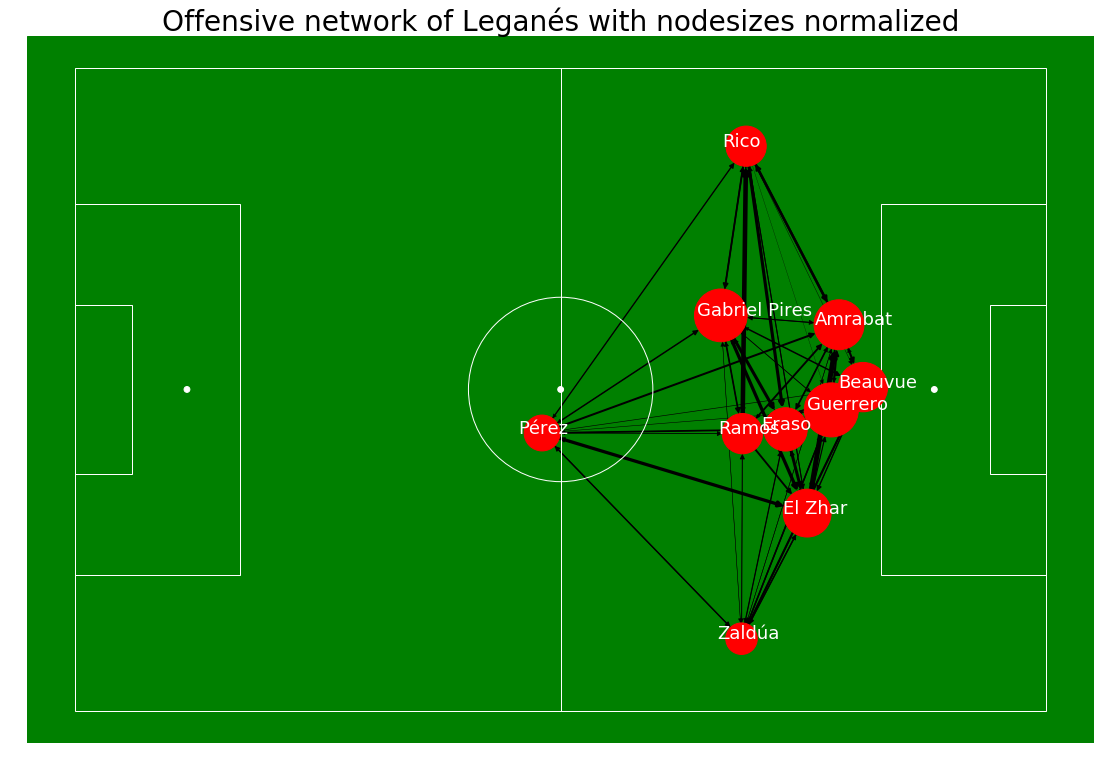

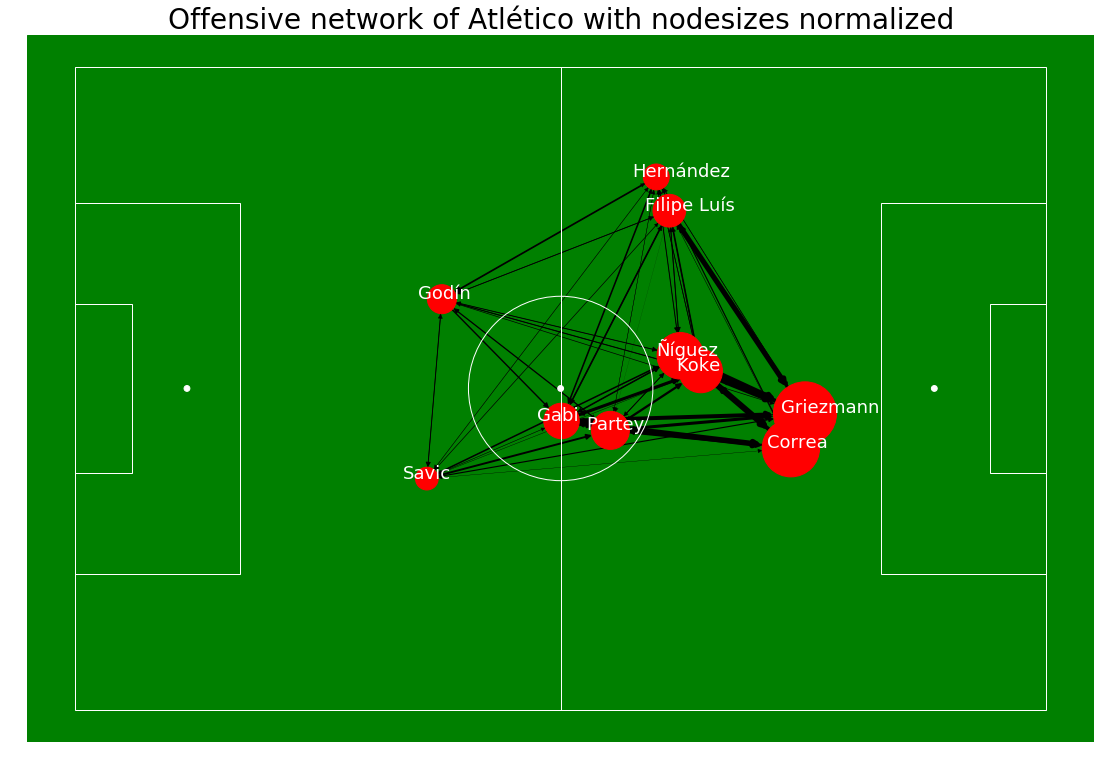

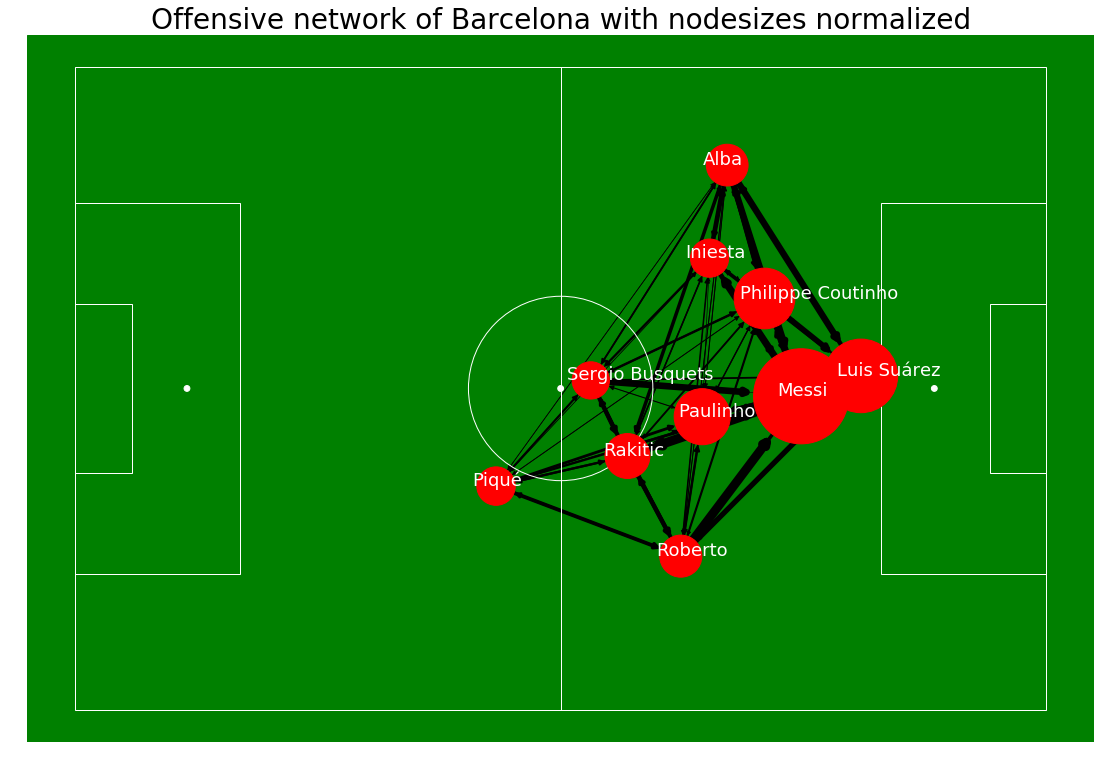

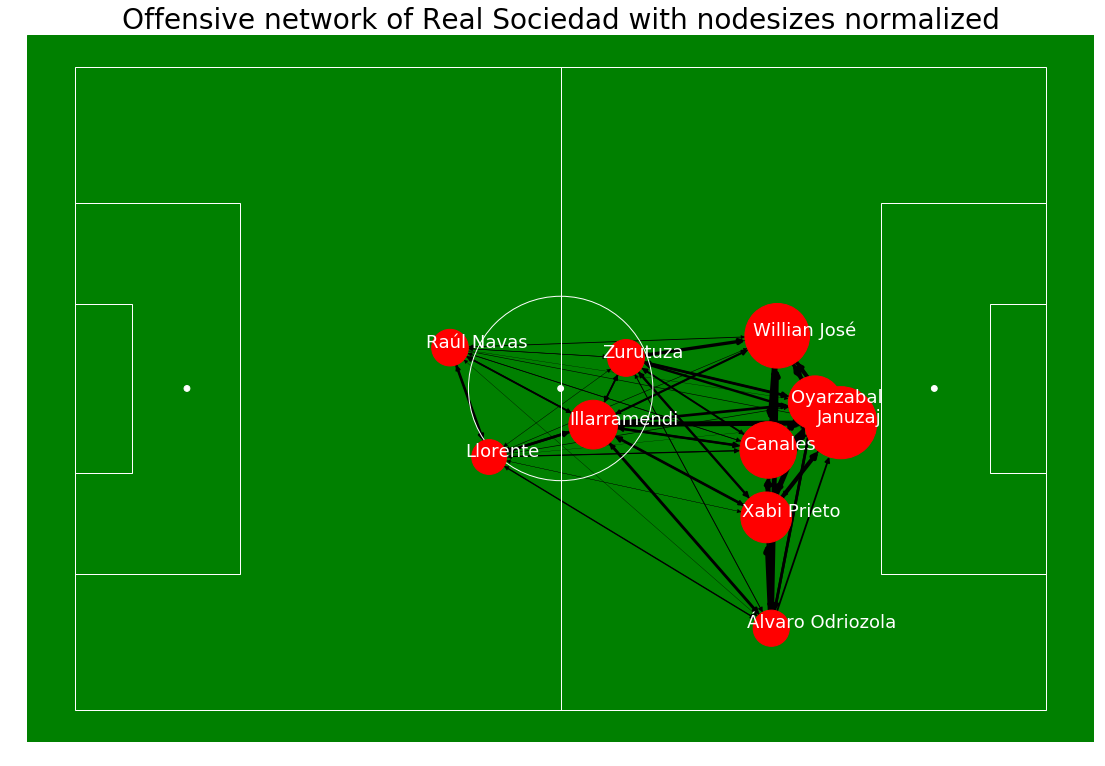

In [32]:
allfiles = os.listdir()
csv_files = [csv for csv in allfiles if csv.endswith(".csv")]

adj_matrix_files = [csv for csv in csv_files if csv.startswith("xg_adj")]
position_files = [csv for csv in csv_files if csv.startswith('positions')]

for i in adj_matrix_files:
    team_id = ''.join([s for s in i if s.isdigit()])
    for j in position_files:
        # if the team number is the same we take i and j as our files to plot stuff
        if team_id == ''.join([n for n in j if n.isdigit()]):
            # reading in the data
            adj_matrix = pd.read_csv(i)
            pos_df = pd.read_csv(j)

            ####################################### preprocessing ####################################
            del pos_df['Unnamed: 0']
            pos_df.columns = ['player_id', 'x', 'y', 'actions']
            pos_df.index = pos_df['player_id']

            # i need the team number of each entry in each list
            adj_matrix.index = adj_matrix['Unnamed: 0'].astype(str)
            del adj_matrix['Unnamed: 0']
            del adj_matrix.index.name


            # for plotting I have to adjust the players position by 5 for x and 5/ratio for y
            pos_df['x'] = pos_df['x'] + 5
            pos_df['y'] = pos_df['y'] + (5 / ratio)

            # subsetting for the eleven players with the highest actions
            pos_df = pos_df.sort_values(by='actions', ascending=False).iloc[0:10]
            size = 400000*pd.merge(pos_df, chance_metric[['player_id', 'metric']], how='left', on='player_id')['metric']
            # getting players names to put labels
            players_of_team = pd.merge(pos_df, allplayers, on='player_id')[['player_id','last_name','known_name', 'x', 'y']]
            players_of_team.index = players_of_team['player_id'].astype(float)

            #### GOTTA MAKE THE ADJ MATRIX 10x10 AT THIS POINT AND ORDER CORRECTLY ################################
            adj_matrix.columns = np.array(adj_matrix.index).astype(float)
            adj_matrix.index = np.array(adj_matrix.index).astype(float)

            # subset adj matrix
            adj_matrix = adj_matrix.loc[players_of_team.index, players_of_team.index]

            # so positions of players I can just append list style, done.
            positions = []
            player_index = []
            for pp in np.array(adj_matrix.index).astype(float):
                if pp in pos_df['player_id']:
                    player_pos = []
                    player_pos.append(pos_df.loc[pp]['x'])
                    player_pos.append(pos_df.loc[pp]['y'])
                    positions.append(player_pos)
                    player_index.append(pp)

            # now only keeping those players in the pos_df frame in the adjacency matrix
            #player_index = [str(x) for x in player_index]

            # subset the matrix for the 11 players found with the most actions
            #adj_matrix = adj_matrix.loc[adj_matrix.columns.isin(player_index),adj_matrix.columns.isin(player_index)]


            #adj_matrix
            adj_matrix.columns = range(len(adj_matrix))
            adj_matrix.index = range(len(adj_matrix))

            ### create the pitch
            ### now plot the graph on top
            graph = nx.DiGraph(adj_matrix)
            # get width of edges
            edges = graph.edges
            weights = [graph[u][v]['weight'] for u,v in edges]
            # different colors to model intensity
            greys = cm = plt.get_cmap('binary')
            cNorm  = colors.Normalize(vmin=min(weights), vmax=max(weights))
            scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=greys)
            colorList = []

            for number_edge in range(len(edges)):
              colorVal = scalarMap.to_rgba(weights[number_edge])
              colorList.append(colorVal)


            # own solution
            topleft=[0,110]
            topright=[110,110]
            bottomleft=[0,0]
            bottomright=[110,0]
            width = abs(topleft[0] - topright[0])
            height = abs(bottomleft[1] - topleft[1])
            xlims = (0, 110)
            ylims = (0, 110/ratio)

            fig1 = plt.figure(figsize=(20,13))
            ax1 = fig1.add_subplot(111, aspect='equal')
            # general green pitch, reaches from 0 - 110 to paint pitch on it
            ax1.add_artist(plt.Circle((55, 55/ratio), 9.5, color='w', fill=False))
            # add penalty point
            ax1.add_artist(plt.Circle((93.5, 55/ratio), 0.3, color='w'))
            # add second point
            ax1.add_artist(plt.Circle((16.5, 55/ratio), 0.3, color='w'))
            # add center point
            ax1.add_artist(plt.Circle((55, 55/ratio), 0.3, color='w'))
            # green surrounding
            ax1.add_patch(
                patches.Rectangle((0, 0/ratio), width, height/ratio, color='g'))
            # marking the field
            ax1.add_patch(
                patches.Rectangle((5, 5/ratio), 100, 100/ratio, fill=False, color='w'))
            # penalty box
            ax1.add_patch(
                patches.Rectangle((5, 26.1/ratio), 17, 57.8/ratio, fill=False, color='w'))
            ax1.add_patch(
                patches.Rectangle((88, 26.1/ratio), 17, 57.8/ratio, fill=False, color='w'))
            ax1.add_patch(
                patches.Rectangle((5, 41.8/ratio), 5.8, 26.4/ratio, fill=False, color='w'))
            ax1.add_patch(
                patches.Rectangle((99.2, 41.8/ratio), 5.8, 26.4/ratio, fill=False, color='w'))
            #nx.draw(graph, positions, node_size = size, width=[w/2.5 for w in weights], edge_color=colorList)
            nx.draw(graph, positions, node_size = size, width=[w*5 for w in weights])
            plt.plot([55, 55], [5/ratio,105/ratio], color='w', linestyle='-', linewidth=1)
            plt.ylim(ylims)
            plt.xlim(xlims)

            ### now add labels of the players names on top
            # players_of_team = pd.merge(pos_df, allplayers, on='player_id')[['player_id','last_name', 'x', 'y']]
            for z in players_of_team['player_id']:
                if pd.isnull(players_of_team.loc[z]['known_name']):
                    plt.annotate(players_of_team.loc[z]['last_name'], xy=(players_of_team.loc[z]['x']-2.5, players_of_team.loc[z]['y']), color='white', fontsize=18)
                else:
                    plt.annotate(players_of_team.loc[z]['known_name'], xy=(players_of_team.loc[z]['x']-2.5, players_of_team.loc[z]['y']), color='white', fontsize=18)

            # add title
            plt.title('Offensive network of ' + str(teams[teams['team_id']==float(team_id)]['short_name'].iloc[0]) + ' with nodesizes normalized', fontsize=28)
            plt.savefig('xg_' + str(team_id) +'_offensive_network_mp.png')

## Most important duos for each team

In [ ]:
#### calculating the most important edges between players for each team
os.chdir('/home/Nickfis/Documents/Projects/football_network_analysis/data')
allfiles = os.listdir()
csv_files = [csv for csv in allfiles if csv.endswith(".csv")]

adj_matrix_files = [csv for csv in csv_files if csv.startswith("xg_adj")]

# creating loop for getting most contributing duos for each team
# create empty list for all teams
teams = []
# create empty list to be filled with arrays of length two with the two most productive players
duos = []
# this list will hold the value added by each of the duos
duo_addedGoals = []

for t in adj_matrix_files:
    # extracting the team_id to save up
    team_id = ''.join([s for s in t if s.isdigit()])
    teams.append(team_id)
    # initiate the value with 0
    duo_value = 0
    # read in the matrix
    adj_matrix = pd.read_csv(t)
    # preprocessing
    adj_matrix.index = adj_matrix['Unnamed: 0']
    del adj_matrix['Unnamed: 0']
    adj_matrix.columns = adj_matrix.index
    # getting loopy
    for i in adj_matrix.index:
        for j in adj_matrix.columns:
            # adding up the values of the adjacency matrix. Incoming and outgoing values between players
            i_to_j = adj_matrix.loc[i,j]
            j_to_i = adj_matrix.loc[j,i]
            overall_value = adj_matrix.loc[i,j] + adj_matrix.loc[j,i]
            # only update the duo_value and the ids if the player combination we look at are having the highest value
            if overall_value > duo_value:
                duo_value = overall_value
                duo_ids = [i,j]
    # get the player id's of the players adding the most value to a team
    duos.append(duo_ids)
    duo_addedGoals.append(duo_value)


duos_df = pd.DataFrame(duos, columns=['player_i', 'player_j']).join(pd.DataFrame(duo_addedGoals, columns=['added_Value'])).join(pd.DataFrame(teams, columns=['team_id']))

#pd.merge(duos_df, allplayers[['player_id', 'last_name']], how='left', left_on=['player_i'], right_on=['player_id'])
# getting the name of the i player_id (take known name if it exists)
# that's why it's so unbelievable ugly code, because we have to go through every row to check whether there is a more recognizable naem
player_i = pd.merge(pd.DataFrame(duos_df['player_i']),allplayers[['player_id', 'last_name', 'known_name', 'real_position']], how='left', left_on=['player_i'], right_on=['player_id'])
player_i.index = player_i['player_i']

for i in player_i.index:
    if player_i.loc[i,'known_name']==player_i.loc[i,'known_name']:
        player_i.loc[i,'last_name'] = player_i.loc[i,'known_name']

player_i = player_i[['player_i', 'last_name', 'real_position']]

player_i.columns = ['player_id', 'i_name', 'i_position']

# create the second player
player_j = pd.merge(pd.DataFrame(duos_df['player_j']),allplayers[['player_id', 'last_name', 'known_name', 'real_position']], how='left', left_on=['player_j'], right_on=['player_id'])
player_j.index = player_j['player_j']

for i in player_j.index:
    if player_j.loc[i,'known_name']==player_j.loc[i,'known_name']:
        player_j.loc[i,'last_name'] = player_j.loc[i,'known_name']

player_j = player_j[['player_j', 'last_name', 'real_position']]

player_j.columns = ['player_id', 'j_name', 'j_position']

# create original dataframe to present
# first add player_i
duos_df = pd.merge(duos_df, player_i, how='left', left_on='player_i', right_on='player_id')
# then add player_j
duos_df = pd.merge(duos_df, player_j, how='left', left_on='player_j', right_on='player_id')
duos_df

# adding teams to the df
teams_df = pd.read_csv('teams.csv')
duos_df['team_id'] = duos_df['team_id'].astype(int)
duos_df = pd.merge(duos_df, teams_df[['team_id', 'short_name']], how='left', on='team_id')

duos_df

duos_df[['short_name','i_name', 'j_name', 'added_Value', 'i_position', 'j_position']].sort_values(by='added_Value', ascending=False).reset_index(drop=True)
i_duos_df